# Hierarchical linear regression: The sleepstudy example


In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams['figure.constrained_layout.use'] = False

In this example we are going to use **sleepstudy** dataset which is derived from the study described in [Belenky et al. (2003)](https://pubmed.ncbi.nlm.nih.gov/12603781/) and popularized in the [`lme4`](https://CRAN.R-project.org/package=lme4) R package. This dataset contains the average reaction time per day (in milliseconds) for the most sleep-deprived group in a sleep deprivation study. The first two days of the study were adaptation and training, the third day was a baseline, and sleep deprivation started after day 3. The subjects in this group were restricted to 3 hours of sleep per night and the average reaction time on a series of tests given each day to each subject was recorded.

## Load data

The **sleepstudy** dataset can be loaded with Bambi using the `load_data()` function:

In [3]:
data = bmb.load_data("sleepstudy")
data

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


The response variable is `Reaction`, the average of the reaction time measurements on a given subject for a given day. The two covariates are `Days`, the number of days of sleep deprivation, and `Subject`, the identifier of the subject on which the observation was made.


## Explore data

Let's get started by displaying the data in a multi-panel layout. There's a panel for each subject in the study. This allows us to observe and compare the association of Days and Reaction between subjects.

In [4]:
def plot_data(data):
    fig, axes = plt.subplots(2, 9, figsize=(16, 7.5), sharey=True, sharex=True, dpi=300)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)

    axes_flat = axes.ravel()

    for i, subject in enumerate(data["Subject"].unique()):
        ax = axes_flat[i]
        idx = data.index[data["Subject"] == subject].tolist()
        days = data.loc[idx, "Days"].values
        reaction = data.loc[idx, "Reaction"].values

        # Plot observed data points
        ax.scatter(days, reaction, color="C0", ec="black", alpha=0.7)

        # Add a title
        ax.set_title(f"Subject: {subject}", fontsize=14)

    ax.xaxis.set_ticks([0, 2, 4, 6, 8])
    fig.text(0.5, 0.02, "Days", fontsize=14)
    fig.text(0.03, 0.5, "Reaction time (ms)", rotation=90, fontsize=14, va="center")

    return axes

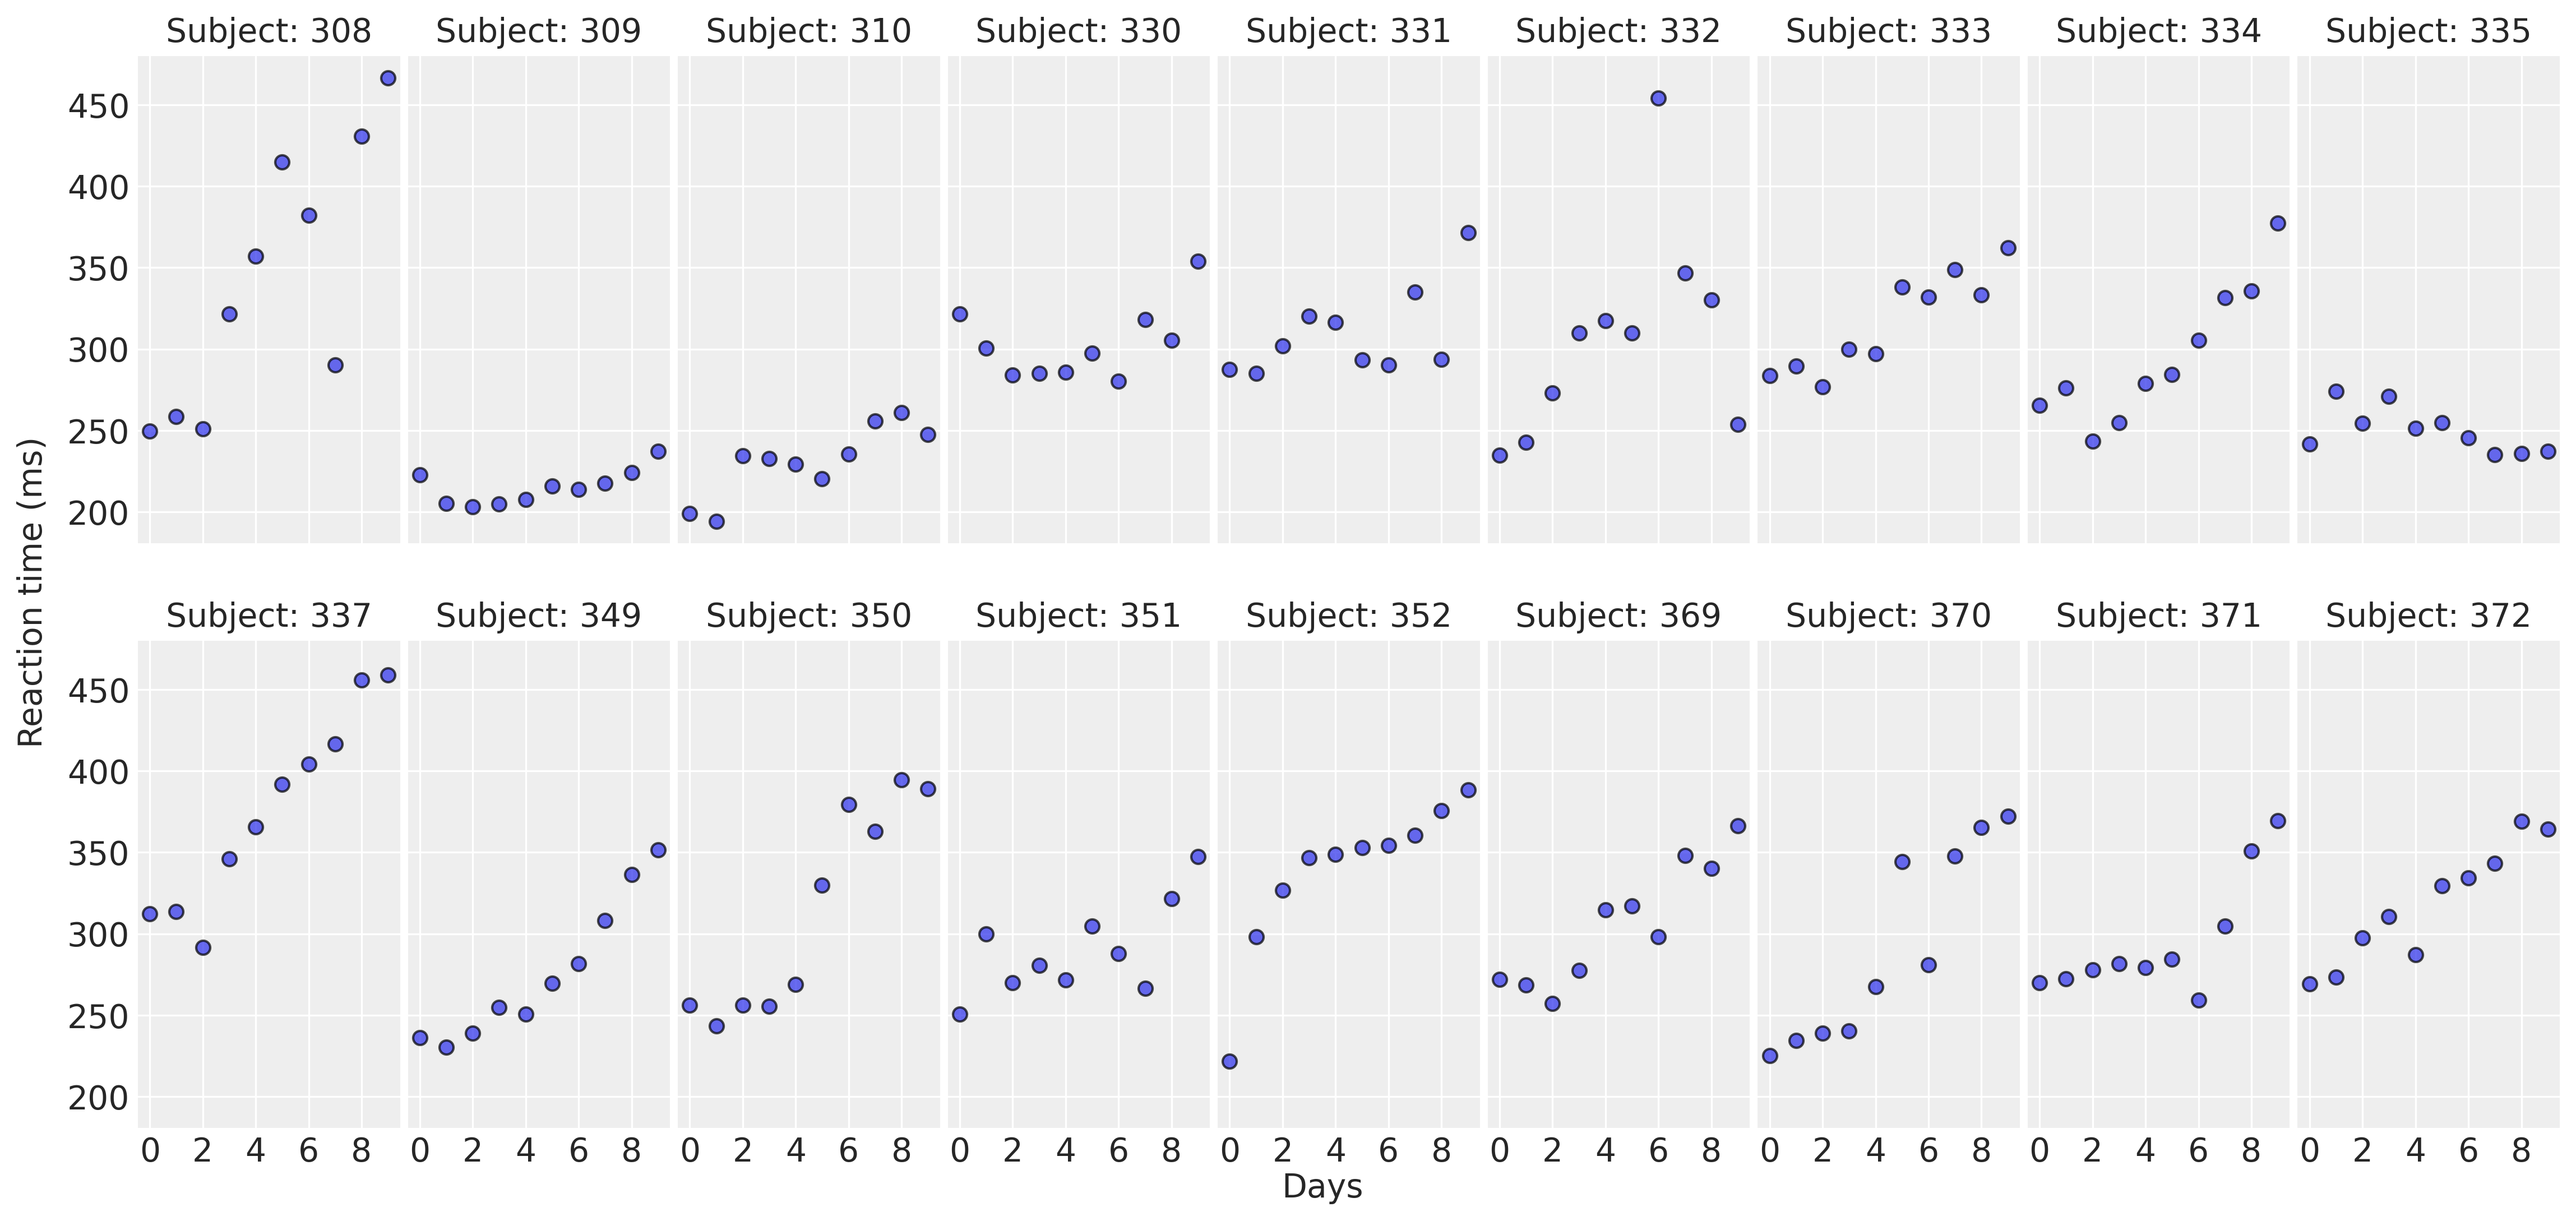

In [5]:
plot_data(data);

For most of the subjects, there's a clear positive association between Days and Reaction time. Reaction times increase as people accumulate more days of sleep deprivation. Participants differ in the initial reaction times as well as in the effect of sleep deprivation and reaction times. Reaction times increase faster for some subjects and slower for others. Finally, the relationship between Days and Reaction time presents some deviations from linearity within the panels, but these are neither substantial nor systematic.

## The model

We're interested in measuring the association between Days and Reaction times. It's important to be aware the observations are longitudinal in nature, i.e they consist of repeated measures on the same subject taken over time. We're going to use a hierarchical linear regression model that includes the effect of a common intercept and slope, as well as intercepts and slopes specific to each subject.

$$
\begin{aligned}
\text{Reaction}_i & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \beta_{\text{Intercept}[i]} + \beta_{\text{Days}[i]}\text{Days}_i \\
\beta_{\text{Intercept}[i]} & = \beta_{\text{Intercept}} + \alpha_{\text{Intercept}_i}\\
\beta_{\text{Days}[i]} & = \beta_{\text{Days}} + \alpha_{\text{Days}_i}\\
\end{aligned}
$$


where $\beta_{\text{Intercept}}$ and $\beta_{\text{Days}}$ are the intercept and day slope effects common to all subjects in the study, and $\alpha_{\text{Intercept}_i}$ and $\alpha_{\text{Days}_i}$ are the group-specific intercept and slope effects for the subjects. These group-specific effects represent the deviation of each subject from the average behavior. 

We use the Bambi's default priors for $\beta_{\text{Intercept}}$, $\beta_{\text{Days}}$, $\alpha_{\text{Intercept}_i}$, $\alpha_{\text{Days}_i}$, and $\sigma$.

Next, let's create the Bambi model. Here we use the formula syntax to specify model in a clear and concise manner. The term on the left side of `~` tells `Reaction` is the response variable. The `Days` term on the right-hand side tells we want to include a slope effect for the `Days` variable common to all subjects. `(Days | Subject)` indicates the `Days` slope for a given subject is going to consist of the common slope plus a deviation specific to that subject.  The common and subject-specific intercepts are added implicitly. We could suppress them by adding a `0` on the common or the group-specific part of the formula (e.g. `0 + Days + (0 + Days|Subject)`).

If we wanted subject-specific intercepts, but not subjec-specific slopes we would have written `Reaction ~ Days + (1 | Subject)` and if we wanted slopes specific to each `Subject` without including a `Subject` specific intercept, we would write `Reaction ~ Days + (0 + Days | Subject)`.

In [6]:
model = bmb.Model("Reaction ~ 1 + Days + (Days | Subject)", data)

We can obtain a description of the model and the priors by just printing the `model` object

In [7]:
model

Formula: Reaction ~ Days + (Days | Subject)
Family name: Gaussian
Link: identity
Observations: 180
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 298.5079, sigma: 261.0092)
    Days ~ Normal(mu: 0.0, sigma: 48.8915)

  Group-level effects
    1|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 261.0092))
    Days|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 48.8915))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 56.1721)


And let's hit the inference button

In [8]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Reaction_sigma, Days|Subject_offset, Days|Subject_sigma, 1|Subject_offset, 1|Subject_sigma, Days, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


## Analyze results

In [9]:
az.summary(idata, var_names=["Intercept", "Days"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,251.433,7.671,237.802,267.171,0.230,0.163,1135.0,1118.0,1.0
Days,10.318,1.706,7.115,13.396,0.066,0.046,681.0,778.0,1.0


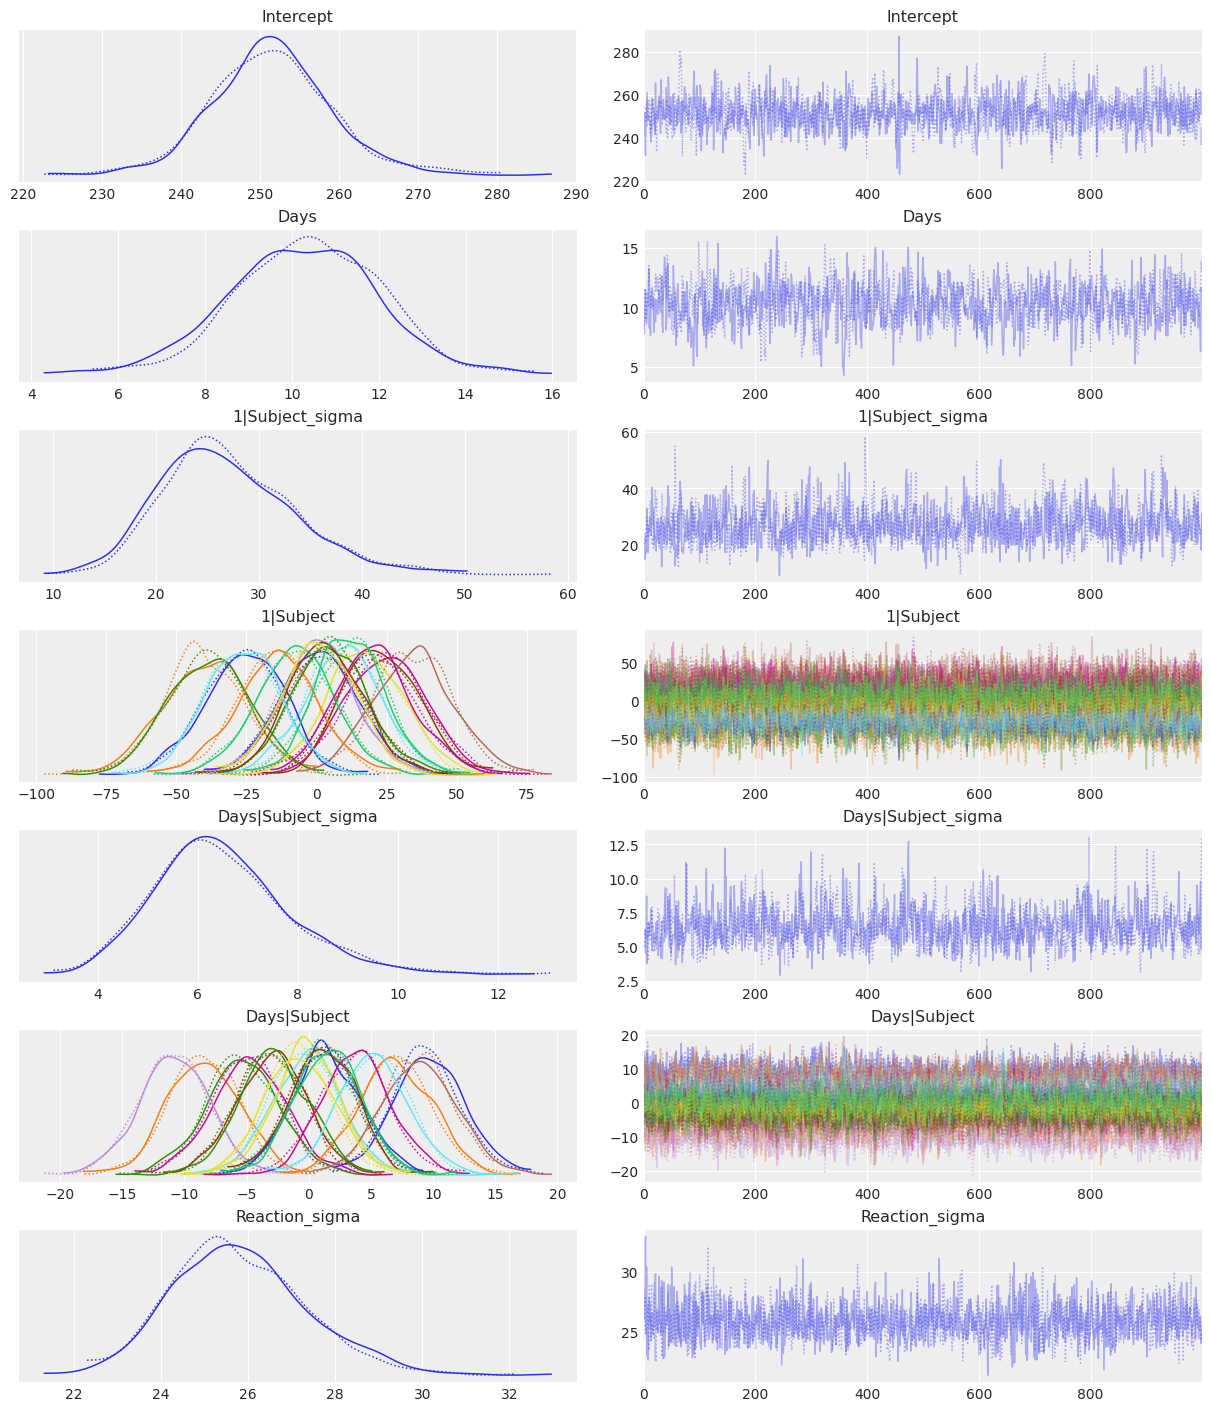

In [10]:
az.plot_trace(idata, backend_kwargs={"constrained_layout": True});

In [11]:
model.predict(idata)

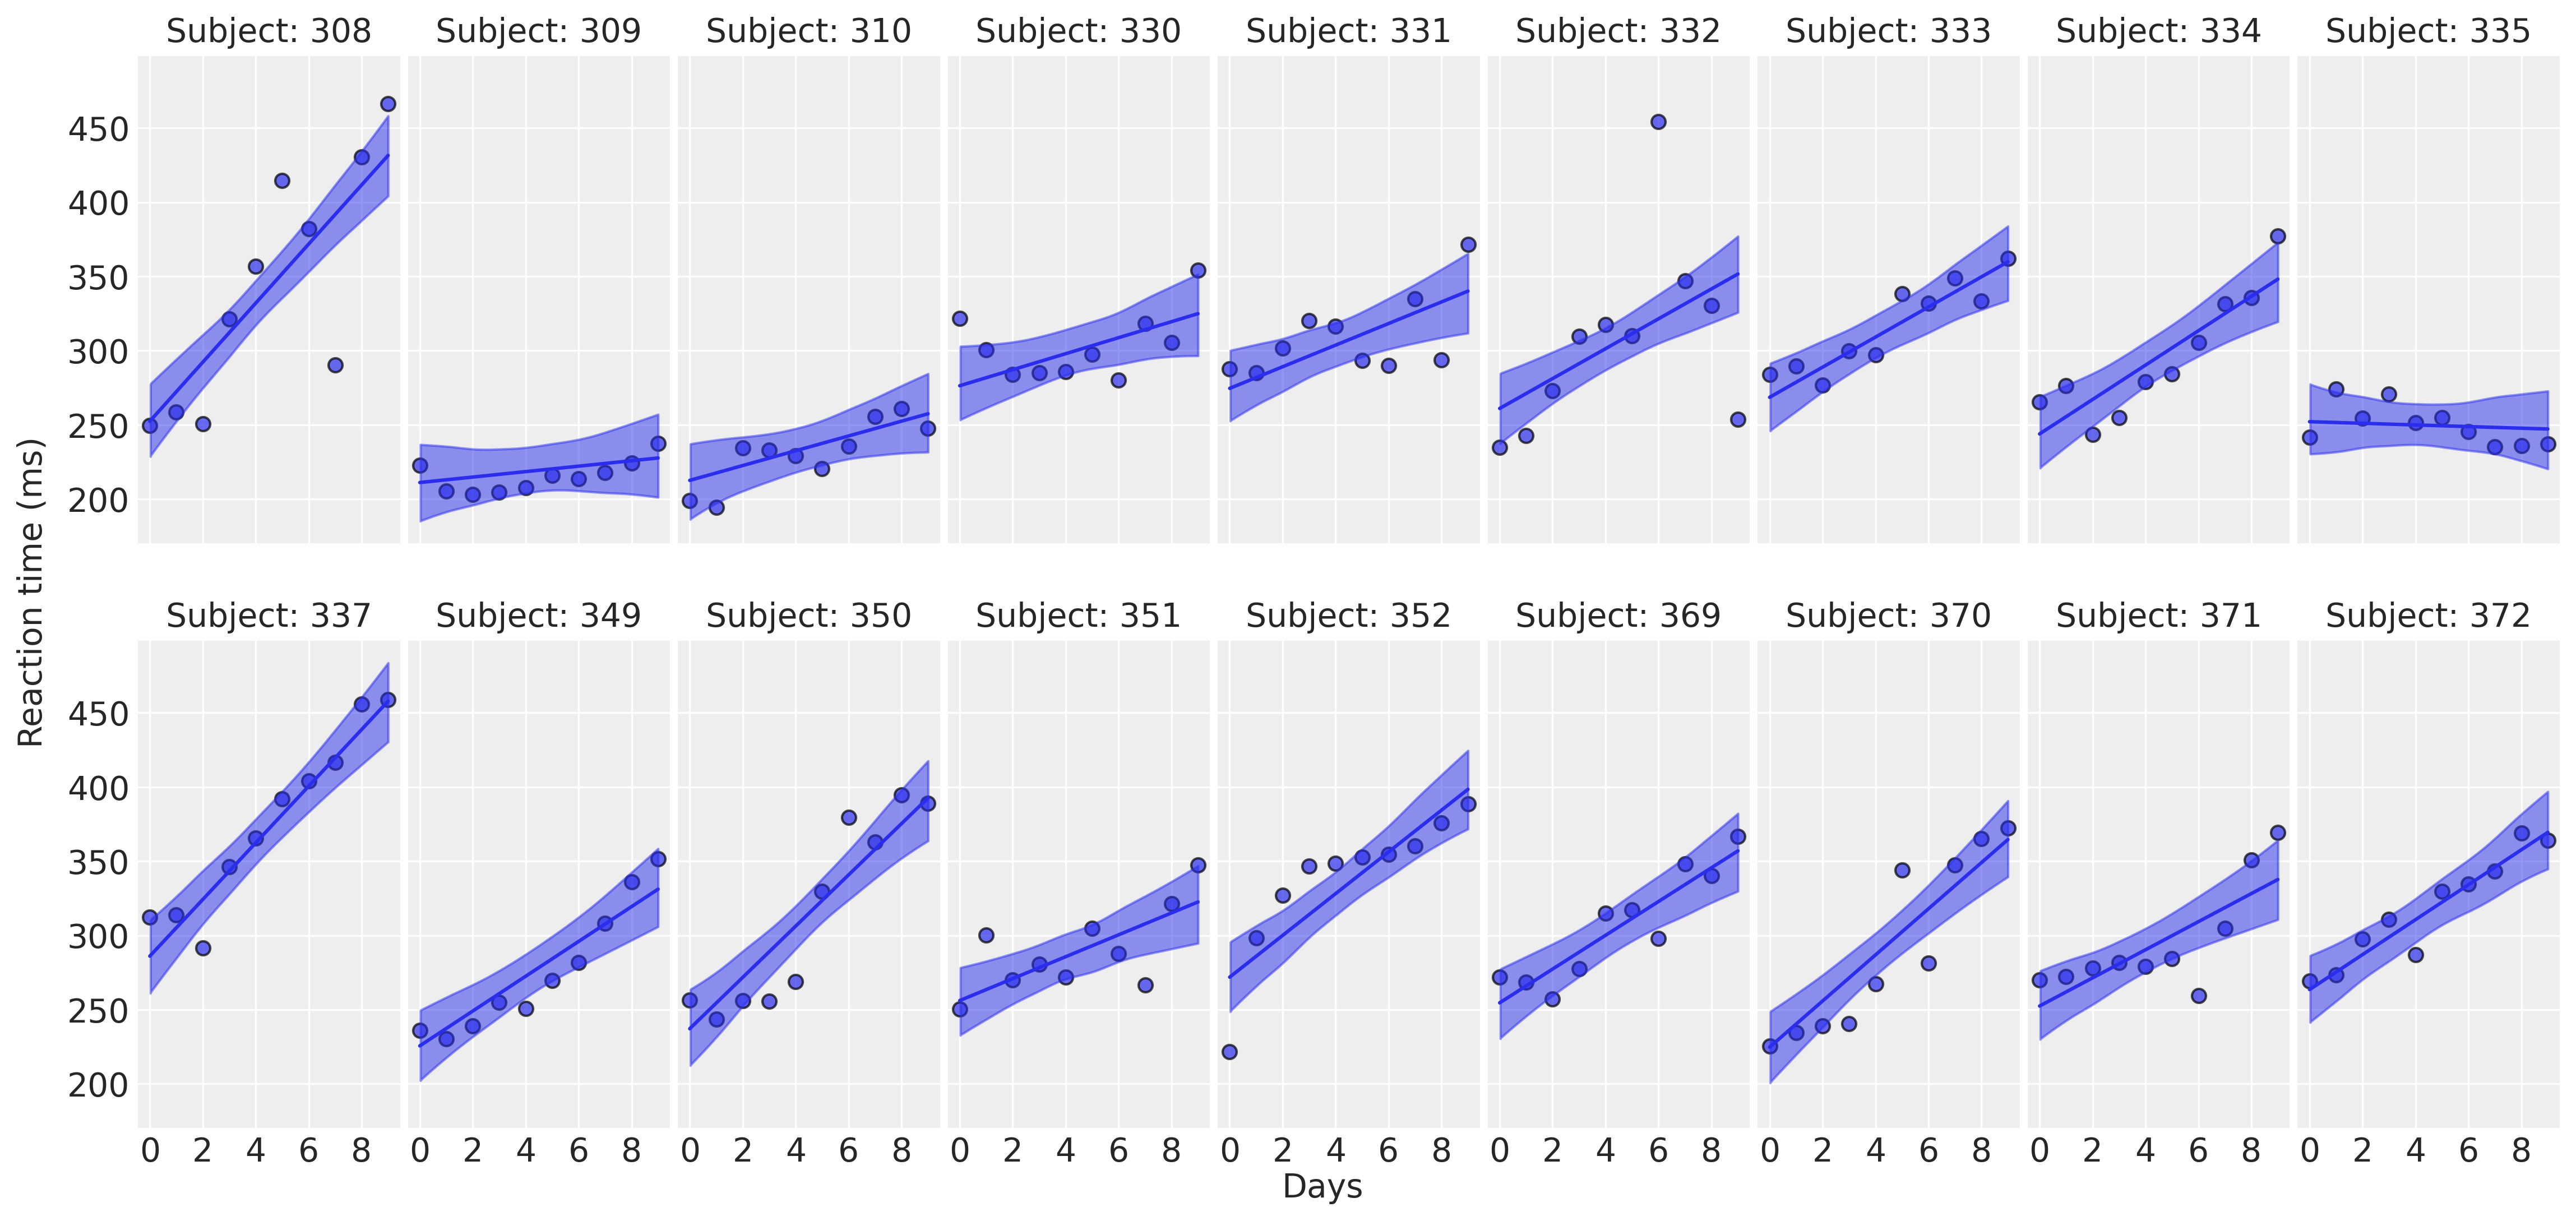

In [15]:
axes = plot_data(data)

axes_flat = axes.ravel()

# Take the posterior of the mean reaction time
reaction_mean = idata.posterior["Reaction_mean"].values

for i, subject in enumerate(data["Subject"].unique()):
    ax = axes_flat[i]
    idx = data.index[data["Subject"]== subject].tolist()
    days = data.loc[idx, "Days"].values
    
    # Plot highest density interval
    az.plot_hdi(days, reaction_mean[:, :, idx], color="C0", ax=ax)
    
    # Plot predicted regression equation
    ax.plot(days, reaction_mean[:, :, idx].mean(axis=(0, 1)), color="C0")

In [22]:
intercept = idata.posterior["1|Subject"].stack(draws=("chain", "draw")).T
slope = idata.posterior["Days|Subject"].stack(draws=("chain", "draw")).T

Text(0, 0.5, 'Subject-specific slope')

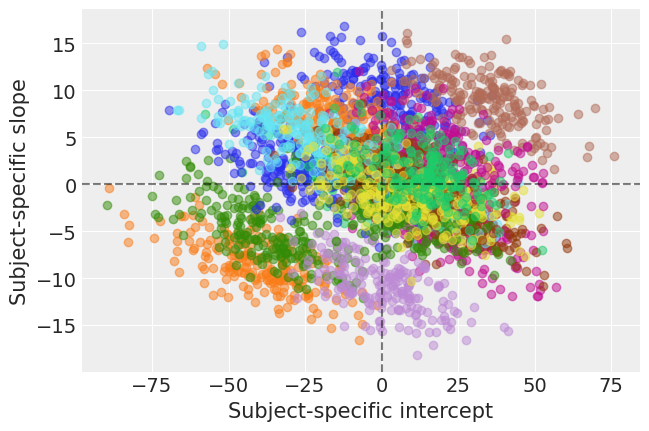

In [35]:
_, ax = plt.subplots()
for group in range(18):
    x = intercept[::10, group]
    y = slope[::10, group]
    ax.scatter(x, y, alpha=0.5)

ax.axhline(c="k", ls="--", alpha=0.5)
ax.axvline(c="k", ls="--", alpha=0.5)
ax.set_xlabel("Subject-specific intercept")
ax.set_ylabel("Subject-specific slope")